In [1]:
import numpy as np # primary math library
import matplotlib.pyplot as plt # primary plotting library
%matplotlib inline

import nelpy as nel # should be installed using pip install nelpy

import warnings
#warnings.filterwarnings("ignore") # useful to prevent excess nelpy warnings

/home/kemerelab/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
# dataroot = '/Users/ckemere/Development/Data/Frank/';
dataroot = '/home/kemerelab/Data/'

In [3]:
import os

filename = os.path.join(dataroot,'MVDMData.nel')
import nelpy.io
jar = nel.load_pkl(filename)

data = jar.Data
del jar


In [4]:
data.keys()

dict_keys(['R042'])

# Calculate tuning curves for all neurons for an example animal

In [5]:
from numpy import unravel_index
    
sigma_500ms = 0.5 # Smoothing for speed calculation
# Bin sizes are 500 ms, and then we slide
ds_run = 0.250 # 250 ms
ds_50ms = 0.05

sigma_250ms = 0.25 # 250 ms spike smoothing

min_duration = 1 # require that estimation periods be at least 1 second long

# Smoothing standard deviation
sigma_tc = 2.5 # tuning curve smoothing std in cm
min_spikes = 5

PFCenters = {}
TuningCurves = {}

for anim, animdata in data.items():
    PFCenters[anim] = {}
    TuningCurves[anim] = {}
    
    for day, daydata in animdata.items():
        print(anim, day)
        S = daydata['spikes']
        pos = daydata['pos']

        # Bins for tuning curves
        if (anim == 'R042'):
            x_extents = [25,225] # Read these off of maze figure above
            y_extents = [0,210]
        
        nx = np.diff(x_extents)/5 # plan for 5 cm bins
        ny = np.diff(y_extents)/5

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_500ms)

        # get_run_epochs is a utility function which wraps a speed threshold. This finds periods where the speed
        #   is greater than v2 and reaches at least a maximum of v1.
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
            run_epochs = pos.support.intersect(run_epochs)  
            run_epochs = run_epochs.intersect(daydata['trial_iv'])

        st_run = S[run_epochs]

        # bin, smooth and re-bin:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma_250ms, inplace=True).rebin(w=ds_run/ds_50ms)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tc = nel.TuningCurve2D(bst=bst_run, extern=pos, 
                                   ext_xmin=x_extents[0], ext_xmax=x_extents[1], 
                                   ext_ymin=y_extents[0], ext_ymax=y_extents[1],
                                   ext_nx=nx, ext_ny=ny,
                                   sigma=sigma_tc, min_duration=1)

        TuningCurves[anim][day] = tc
        PFCenters[anim][day] = []

        for idx, pf in enumerate(tc.ratemap):
            placefield = pf.T
            peak = unravel_index(placefield.squeeze().argmax(),placefield.shape)
            PFCenters[anim][day].append([idx, placefield.max(), peak[0], peak[1]])

    


R042 2013-08-18


# Plot an example tuning curve

In [6]:
anim = 'R042'
day = '2013-08-18'

/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


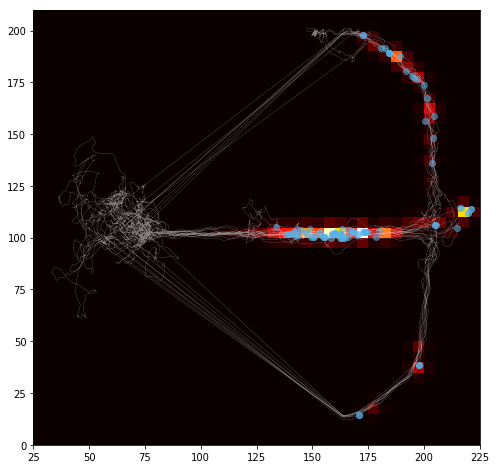

In [7]:
import nelpy.plotting as npl

tc = TuningCurves[anim][day]
xx_mid = tc.xbin_centers
yy_mid = tc.ybin_centers

S = data[anim][day]['spikes']
pos = data[anim][day]['pos']

speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_500ms)
run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
run_epochs = pos.support.intersect(run_epochs)  
run_epochs = run_epochs.intersect(daydata['trial_iv'])
runpos = pos[run_epochs]


fig, ax = plt.subplots(1,1, figsize = (8, 8))

xvals, yvals = runpos.simplify(n_points=5000).asarray().yvals

nidx = 2
xspks, yspks = runpos.asarray(at=S[run_epochs].time[nidx]).yvals

ax.set_aspect('equal')
placefield = tc.ratemap[nidx]
npl.imagesc(x=xx_mid, y=yy_mid, data=placefield.T, cmap=plt.cm.hot, ax=ax)
ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
ax.plot(xspks, yspks, 'o', color=npl.colors.sweet.blue, alpha=0.5)



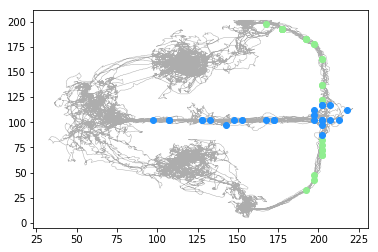

In [8]:
from shapely.geometry import box, Point

fig, ax = plt.subplots()
PF_data = {}

for day, daydata in data[anim].items():
    # The animal "Bon" had good data on day 3
    S = daydata['spikes']
    pos = daydata['pos']
    # Find placefield centers
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tvals, vals = pos.asarray() # Access timestamps and channel data as numpy arrays
    xvals, yvals = vals # Access two channels as x and y
    ax.plot(xvals, yvals, lw=0.5, c='0.2', alpha=0.4)

for day, daydata in data[anim].items():
    maxrate = np.array(PFCenters[anim][day])
    maxrate = maxrate[:,1]
    p = np.array(PFCenters[anim][day],dtype=int)
    pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T
    
    # Find left and right arm PFs using shapely
    left_box = box(*daydata['LeftArmRect'])
    right_box = box(*daydata['RightArmRect'])
    left = [left_box.contains(Point(p)) for p in pfcenters]
    right = [right_box.contains(Point(p)) for p in pfcenters]
    center = np.logical_and(np.logical_not(left), np.logical_not(right))
    
    left = np.logical_and(left, maxrate > 2)
    right = np.logical_and(right, maxrate > 2)
    center = np.logical_and(center, maxrate > 2)
    inactive = maxrate <= 2

    ax.plot(pfcenters[left,0], pfcenters[left,1],'o',c='lightgreen')
    ax.plot(pfcenters[right,0], pfcenters[right,1],'o',c='lightgreen')
    ax.plot(pfcenters[center,0], pfcenters[center,1],'o',c='dodgerblue')
    
    PF_data[day] = np.column_stack((np.array(PFCenters[anim][day]), np.array(inactive), 
                              np.array(center), np.array(left), np.array(right)));

    # S = daydata['spikes']
    # print(PF_data[day].shape, S.n_units, left.shape, right.shape, center.shape, inactive.shape)



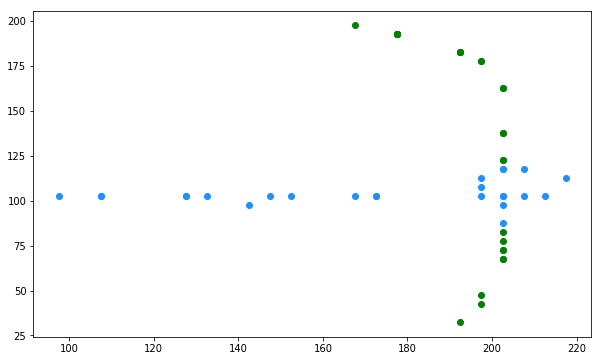

In [9]:
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):    
    maxrate = np.array(PFCenters[anim][day])
    maxrate = maxrate[:,1]
    p = np.array(PFCenters[anim][day],dtype=int)
    pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T

    # Find left and right arm PFs using shapely
    left_box = box(*daydata['LeftArmRect'])
    right_box = box(*daydata['RightArmRect'])
    left = [left_box.contains(Point(p)) for p in pfcenters]
    right = [right_box.contains(Point(p)) for p in pfcenters]
    center = np.logical_and(np.logical_not(left), np.logical_not(right))
    
    left = np.logical_and(left, maxrate > 2)
    right = np.logical_and(right, maxrate > 2)
    center = np.logical_and(center, maxrate > 2)
    inactive = maxrate <= 2
    
    ax.plot(pfcenters[left,0], pfcenters[left,1],'o',c='green')
    ax.plot(pfcenters[right,0], pfcenters[right,1],'o',c='green')
    ax.plot(pfcenters[center,0], pfcenters[center,1],'o',c='dodgerblue')


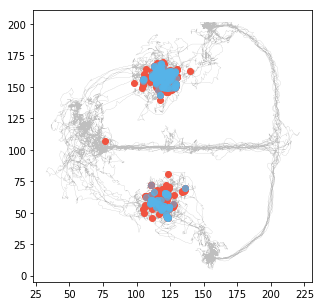

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
swr_eps = data[anim][day]['event-candidates']
#for ep in epochs:
pos = data[anim][day]['pos']
speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_500ms)

not_still_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # bound epochs down to 1 cm/s
still_epochs = pos.support.intersect(not_still_epochs.complement()) 
still_pos = pos.support.intersect(still_epochs)

all_swr = swr_eps.intersect(pos.support)
allswrtimes = all_swr.centers
still_swr = swr_eps.intersect(still_epochs)
stillswrtimes = still_swr.centers

posx, posy = pos.asarray().yvals 
ax.plot(posx, posy, lw=0.25, color='gray', alpha=0.5)
xswr, yswr = pos.asarray(at=allswrtimes).yvals
ax.plot(xswr, yswr, 'o', color=npl.colors.sweet.red)
xswr1, yswr1 = pos.asarray(at=stillswrtimes).yvals
ax.plot(xswr1, yswr1, 'o', color=npl.colors.sweet.blue, alpha=0.5)





In [11]:
import pandas as pd

swr_table = []

for day, daydata in data[anim].items():
    swr_eps = daydata['event-candidates']

    S = daydata['spikes']
    print(day, S.n_units)

    pos = daydata['pos']
    # with warnings.catch_warnings():
    #    warnings.simplefilter("ignore")
    #    speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)

    # with warnings.catch_warnings():
    #    warnings.simplefilter("ignore")
    #    not_still_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # bound epochs down to 1 cm/s
    #    still_epochs = pos[epochs,:].support.intersect(not_still_epochs.complement()) 
    #    still_pos = pos[epochs,:].support.intersect(still_epochs)

    # with warnings.catch_warnings():
    #    warnings.simplefilter("ignore")
    #    all_swr = swr_eps.intersect(pos[epochs,:].support)

    all_swr = swr_eps
    allswrtimes = all_swr.centers
    # still_swr = swr_eps.intersect(still_epochs)
    # stillswrtimes = still_swr.centers

    # swr_spikes = S[still_swr]
    swr_spikes = S[all_swr]
    
    swrtimes = allswrtimes

    isi = np.insert(np.diff(swrtimes),0,-np.nan)
    for idx, swr in enumerate(swr_spikes):
        swr_table.append([
            swrtimes[idx],
            isi[idx],
            swr.iloc[:,np.argwhere(PF_data[day][:,4])].n_active,
            swr.iloc[:,np.argwhere(PF_data[day][:,5])].n_active,
            swr.iloc[:,np.argwhere(PF_data[day][:,6])].n_active,
            swr.iloc[:,np.argwhere(PF_data[day][:,7])].n_active,
        ])

swr_df = pd.DataFrame(swr_table,columns=['time','isi','inactive','center','left','right'])
        


2013-08-18 107


In [12]:
swr.iloc[:,np.argwhere(PF_data[day][:,4])]

<SpikeTrainArray at 0x7fb01024ac88: 56 units> at 30000 Hz

In [13]:
left_isi = []
right_isi = []
center_isi = []
inactive_isi = []

last_left = np.nan
last_right = np.nan
last_center = np.nan
last_inactive = np.nan

for idx, row in swr_df.iterrows():
    if np.isnan(row['isi']):
        last_left = np.nan
        last_right = np.nan
        last_center = np.nan
        last_inactive = np.nan

    if row['left'] > 0:
        if ~np.isnan(last_left):
            left_isi.append( (row['time'] - last_left)/row['isi'] )
        last_left = row['time']
        
    if row['right'] > 0:
        if ~np.isnan(last_right):
            right_isi.append( (row['time'] - last_right)/row['isi'] )
        last_right = row['time']
        
    if row['center'] > 0:
        if ~np.isnan(last_center):
            center_isi.append(row['time'] - last_center)
        last_center = row['time']
        
    if row['inactive'] > 0:
        if ~np.isnan(last_inactive):
            inactive_isi.append(row['time'] - last_inactive)
        last_inactive = row['time']


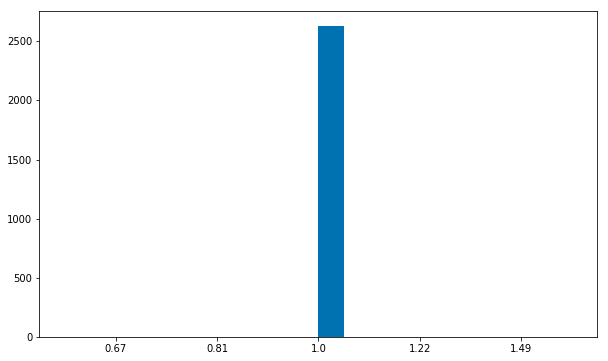

In [14]:
import seaborn as sns
sns.set_palette('colorblind')
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):
    #sns.distplot(np.log(inter_swr_intervals),hist=True,norm_hist=True,bins=50,label='SWR');
    #sns.distplot(np.log(inactive_isi),hist=True,norm_hist=True,bins=25,label='Inactive');
    #sns.distplot(np.log(center_isi),hist=True,norm_hist=True,bins=50,label='Center');
    #sns.distplot(np.log(left_isi),hist=True,norm_hist=True,bins=25,label='Left');
    #sns.distplot(np.log(right_isi),hist=True,norm_hist=True,bins=25,label='Right');
    ax.hist(np.log(right_isi+left_isi),bins=20,label='Same Arm');
    #ax.set_xticks(np.log([1,3,10,30,100,300,1000]))
    ax.set_xticklabels(np.exp(ax.get_xticks()).astype('|U4'))


# Plot firing rate maps of all neurons by detected arm center

/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


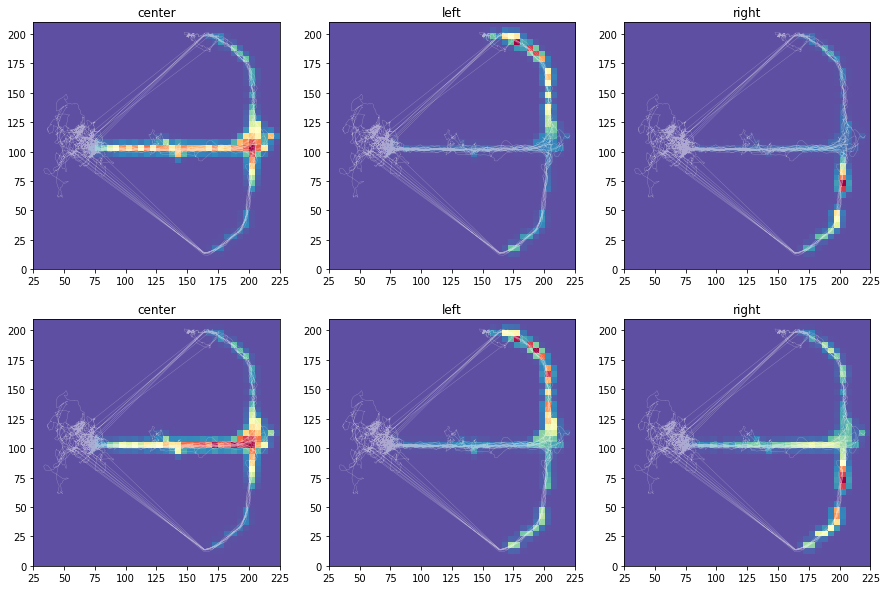

In [15]:
tc = TuningCurves[anim][day]
xx_mid = tc.xbin_centers
yy_mid = tc.ybin_centers

S = data[anim][day]['spikes']
pos = data[anim][day]['pos']

speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_500ms)
# run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
# run_epochs = pos[epochs,:].support.intersect(run_epochs)  
run_epochs = data[anim][day]['trial_iv']
runpos = pos[run_epochs]
xvals, yvals = runpos.simplify(n_points=5000).asarray().yvals


fig, ax = plt.subplots(2, 3, figsize = (15, 10))
axis_order = ['center', 'left', 'right']
for idx, axis in enumerate(axis_order):    
    ax[0,idx].set_aspect('equal')
    all_pfs = tc.ratemap[PF_data[day][:,idx + 5]==1,:,:]
    norm_pfs = all_pfs.T / all_pfs.sum(axis=2).sum(axis=1)
    total_pfs = norm_pfs.mean(axis=2)
    npl.imagesc(x=xx_mid, y=yy_mid, data=total_pfs, cmap=plt.cm.Spectral_r, ax=ax[0,idx])
    ax[0,idx].plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
    ax[0,idx].set_title(axis)

    ax[1,idx].set_aspect('equal')
    all_pfs = tc.ratemap[PF_data[day][:,idx + 5]==1,:,:].sum(axis=0)
    npl.imagesc(x=xx_mid, y=yy_mid, data=all_pfs.T, cmap=plt.cm.Spectral_r, ax=ax[1,idx])
    ax[1,idx].plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
    ax[1,idx].set_title(axis)




# Define left and right 2D maze zones

In [16]:
nx = TuningCurves[anim][day].n_xbins
ny = TuningCurves[anim][day].n_ybins
xx_mid = TuningCurves[anim][day].xbin_centers
yy_mid = TuningCurves[anim][day].ybin_centers

# Find left and right arm PFs using shapely
left_box = box(*data[anim][day]['LeftArmRect'])
right_box = box(*data[anim][day]['RightArmRect'])

left_pixels = np.zeros((int(nx),int(ny)))
right_pixels = np.zeros((int(nx),int(ny)))
for ix, x in enumerate(xx_mid):
    for iy, y in enumerate(yy_mid):
        left_pixels[ix,iy] = left_box.contains(Point([x,y]))
        right_pixels[ix,iy] = right_box.contains(Point([x,y]))
        

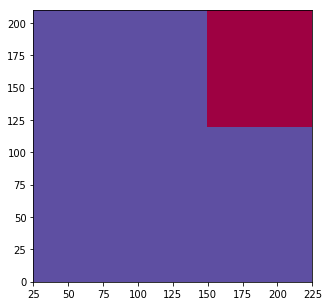

In [17]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_aspect('equal')
ax, img = npl.imagesc(x=xx_mid, y=yy_mid, data=left_pixels.T, cmap=plt.cm.Spectral_r, ax=ax)



/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:898: UserWarning: ignoring spikes outside of spiketrain support


-1381.67878801


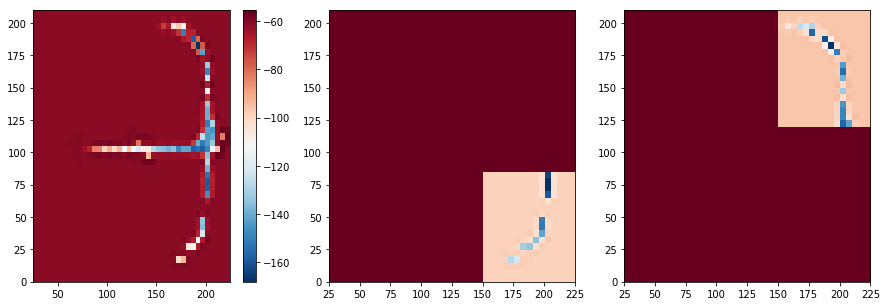

In [18]:
day = '2013-08-18'

tc = TuningCurves[anim][day]
ratemap = tc.ratemap
swr_eps = data[anim][day]['event-candidates']
S = data[anim][day]['spikes']        
pos = data[anim][day]['pos']

swr_spikes = S[swr_eps]
swrtimes = swr_eps.centers

swr = swr_spikes[0]
bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)
left_odds = (bayes_estimate * left_pixels.T).sum()
right_odds = (bayes_estimate * right_pixels.T).sum()

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].set_aspect('equal')
ax[0], img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate, cmap=plt.cm.RdBu_r, ax=ax[0])
plt.colorbar(img, ax=ax[0])

ax[1].set_aspect('equal')
a, img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate * right_pixels.T, cmap=plt.cm.RdBu_r, ax=ax[1])

ax[2].set_aspect('equal')
a, img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate * left_pixels.T, cmap=plt.cm.RdBu_r, ax=ax[2])

left_odds = (bayes_estimate * left_pixels.T).sum()
right_odds = (bayes_estimate * right_pixels.T).sum()

print(left_odds-right_odds)


# Decode each ripple's total position and odds over maze zones

In [19]:
def calculate_shuffle_odds(swr, ratemap, left_pixels, right_pixels, n_shuffles=500):
    if swr.n_active == 0:
        return (np.nan, 0)

    NN = ratemap.shape[0]
    bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)
    left_odds = (bayes_estimate * left_pixels.T).sum()
    right_odds = (bayes_estimate * right_pixels.T).sum()

    true_odds = left_odds - right_odds

    shuf_odds = []
    for n in range(n_shuffles):
        shuf_rate = ratemap.copy()
        shuf_rate = shuf_rate[np.random.permutation(NN),:,:]
        shuf_est = -shuf_rate.sum(axis=0).T + np.log(shuf_rate.T).dot(swr.n_spikes)
        left_odds = (shuf_est * left_pixels.T).sum()
        right_odds = (shuf_est * right_pixels.T).sum()
        shuf_odds.append(left_odds - right_odds)
        
    return (true_odds, shuf_odds)


In [48]:
from joblib import Parallel, delayed
from scipy import stats
import time


RippleArmScores = {}

for anim, animdata in data.items():
    RippleArmScores[anim] = {}
    if anim != 'R042':
        continue
    
    for day, daydata in animdata.items():
        print(anim, day)
        t0 = time.time()


        ########################################################
        # Calculate pixel bins for left and right decoding areas
        nx = TuningCurves[anim][day].n_xbins
        ny = TuningCurves[anim][day].n_ybins
        xx_mid = TuningCurves[anim][day].xbin_centers
        yy_mid = TuningCurves[anim][day].ybin_centers
        
        # Find left and right arm PFs using shapely
        left_box = box(*data[anim][day]['LeftArmRect'])
        right_box = box(*data[anim][day]['RightArmRect'])

        left_pixels = np.zeros((int(nx),int(ny)))
        right_pixels = np.zeros((int(nx),int(ny)))
        for ix, x in enumerate(xx_mid):
            for iy, y in enumerate(yy_mid):
                left_pixels[ix,iy] = left_box.contains(Point([x,y]))
                right_pixels[ix,iy] = right_box.contains(Point([x,y]))
        ########################################################

        t1 = time.time()
        print('Pixel areas decided', t1-t0, 's')

        ratemap = TuningCurves[anim][day].ratemap
        swr_eps = data[anim][day]['event-candidates']
        S = daydata['spikes']        
        pos = daydata['pos']

        if (swr_eps.n_epochs < 20):
            continue
        
        RippleArmScores[anim][day] = {}
        
        # Make all events 150 ms long
        # centers = swr_eps.centers
        # new_bnds = np.vstack([centers-0.05, centers+0.05])
        # new_epochs = nel.EpochArray(new_bnds.T)

        RippleArmScores[anim][day]['RippleEpochs'] = swr_eps
        # RippleArmScores[anim][day]['RippleEpochs'] = new_epochs

        swrtimes = swr_eps.starts
        # swrtimes = new_epochs.centers
        isi = np.insert(np.diff(swrtimes),0,-np.nan)
        RippleArmScores[anim][day]['TimeSinceLastRipple'] = isi

        print('Scoring starting')

        swr_spikes = S[swr_eps]

        results = Parallel(n_jobs=30)(delayed(calculate_shuffle_odds)(swr, 
                                ratemap, left_pixels, right_pixels) for swr in swr_spikes)
        t2 = time.time()
        print('Done in ', t2-t1, 's')

        true_odds, shuf_odds = zip(*results)

        RippleArmScores[anim][day]['TrueOdds'] = true_odds
        RippleArmScores[anim][day]['OddsShuffles'] = shuf_odds

        shuf_ratio = []
        for idx, t in enumerate(true_odds):
            if not np.isnan(t):
                shuf_ratio.append(stats.percentileofscore(shuf_odds[idx],t))
            else:
                shuf_ratio.append(np.nan)
                
        shuf_ratio = np.array(shuf_ratio)
        RippleArmScores[anim][day]['TruePercentiles'] = shuf_ratio
        RippleArmScores[anim][day]['ScoreOfLastRipple'] = np.hstack([np.nan, shuf_ratio[:-1]])

        shuf_ratio2 = np.zeros(shuf_ratio.shape)
        shuf_ratio2[shuf_ratio > 75] = 1.0
        shuf_ratio2[shuf_ratio < 25] = -1.0
        RippleArmScores[anim][day]['TruePercentilesThresholded'] = shuf_ratio2
        RippleArmScores[anim][day]['ScoreOfLastRippleThresholded'] = np.hstack([0, shuf_ratio2[:-1]])
        
        print(len(isi), len(np.hstack([shuf_ratio[1:], np.nan])))
    

R042 2013-08-18
Pixel areas decided 0.04871821403503418 s
Scoring starting
Done in  206.38996195793152 s
1315 1315


# Plot an example event

/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:898: UserWarning: ignoring spikes outside of spiketrain support
/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Text(0.5,1,'Percentile = 89.4')

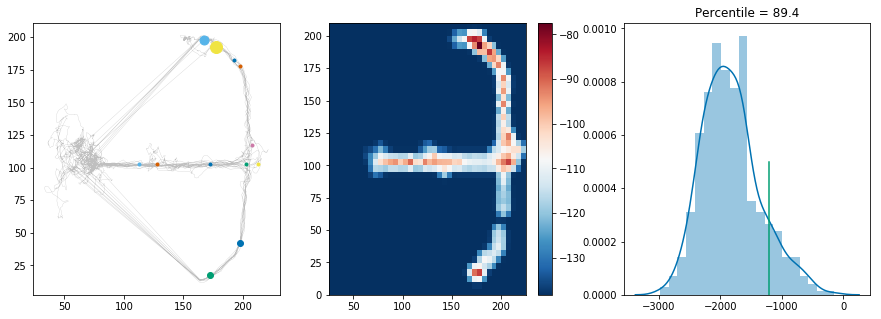

In [90]:
day = '2013-08-18'

swr_eps = data[anim][day]['event-candidates']
S = data[anim][day]['spikes']        
pos = data[anim][day]['pos']

p = np.array(PFCenters[anim][day],dtype=int)
pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T


swr_spikes = S[swr_eps]

ratemap = TuningCurves[anim][day].ratemap * 0.1


ex = 7

swr = swr_spikes[ex]

fig, ax = plt.subplots(1,3,figsize=(15,5))


run_epochs = data[anim][day]['trial_iv']
runpos = pos[run_epochs]
xvals, yvals = runpos.simplify(n_points=5000).asarray().yvals
ax[0].plot(xvals, yvals, lw=0.25, color='gray', alpha=0.5)

for nidx, n in enumerate(swr.n_spikes):
    if n > 0:
        ax[0].plot(pfcenters[nidx][0],pfcenters[nidx][1],'o',markersize=3*n);
    


bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)
left_odds = (bayes_estimate * left_pixels.T).sum()
right_odds = (bayes_estimate * right_pixels.T).sum()

true_odds = left_odds - right_odds

ax[1].set_aspect('equal')
ax[1], img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate, cmap=plt.cm.RdBu_r, ax=ax[1])
plt.colorbar(img, ax=ax[1])

sns.distplot(RippleArmScores[anim][day]['OddsShuffles'][ex], ax=ax[2])
ax[2].plot(RippleArmScores[anim][day]['TrueOdds'][ex]*np.ones(2),np.array([0,0.0005]))
ax[2].set_title('Percentile = {}'.format(RippleArmScores[anim][day]['TruePercentiles'][ex]))


In [109]:
ds = 0.01 # 10 millisecond bins should be ok?
swr_events = nel.SpikeTrainArray(swr_eps.centers)
expanded_support = swr_events.support.expand(5)
swr_events = nel.SpikeTrainArray(swr_eps.centers, support=expanded_support)
binned_swr_events = nel.BinnedSpikeTrainArray(swr_events, ds=ds)
print((swr_eps.centers[-1] - swr_eps.centers[0])/ds)
print(binned_swr_events.data.shape)

442151.95
(1, 443151)


/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:532: UserWarning: No sampling rate was specified! Assuming default of 30000 Hz.


In [178]:
score_time_series = np.zeros(binned_swr_events.data.shape)
score_time_series[binned_swr_events.data==1] = (RippleArmScores[anim][day]['TruePercentiles'] - 50)/100

In [230]:
import scipy
sigma = 5 # 50 ms smoothing

smoothed_scoreTS = scipy.ndimage.filters.gaussian_filter1d(score_time_series,sigma=sigma)

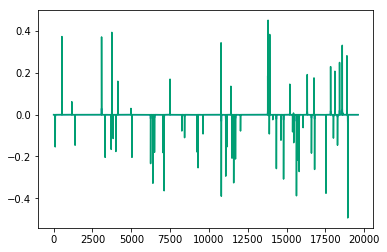

In [231]:
plt.plot(smoothed_scoreTS.T[400:20000])
plt.plot(score_time_series.T[400:20000])

In [126]:
print(np.dot(score_time_series,score_time_series.T))

print(np.inner(score_time_series,score_time_series))

[[ 4073225.68]]
[[ 4073225.68]]


In [281]:
def autocorrelate(x, NA=10000):
    autocor = np.zeros(NA)
    for lag in range(NA):
        if lag == 0:
            autocor[lag] = np.inner(x, x)/len(x)
        else:
            autocor[lag] = np.inner(x[:-lag], x[lag:]) / len(x[lag:])
            
    return autocor

In [282]:
autocor = autocorrelate(smoothed_scoreTS.squeeze())

In [212]:
autocor.shape

(10000,)

(-0.0025, 0.0025)

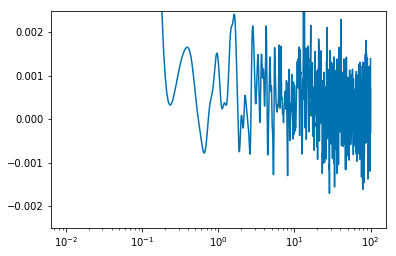

In [233]:
plt.semilogx(np.arange(NA-1)*ds, autocor[1:]*(1/ds)*(1/ds))
plt.gca().set_ylim(-0.0025,0.0025)


# Generate shuffled event autocorrelations

In [236]:
score_time_series.shape

(1, 443151)

In [283]:
def shuffle_autocorrelation(event_indices, event_values, nbins, sigma):
    shuf_time_series = np.zeros(nbins)
    shuf_time_series[event_indices] = np.random.permutation(event_values)
    smoothed_shuf = scipy.ndimage.filters.gaussian_filter1d(shuf_time_series,sigma=sigma)
    return autocorrelate(smoothed_shuf.T)
    

In [267]:
binned_swr_events.data.shape

(1, 443151)

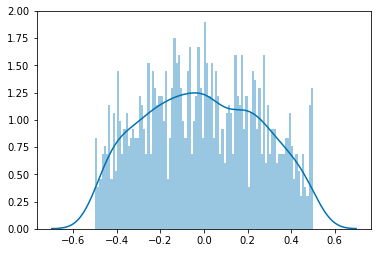

In [303]:
sns.distplot((RippleArmScores[anim][day]['TruePercentiles'] - 50)/100,100)

In [311]:
raw_autocor = autocorrelate( (RippleArmScores[anim][day]['TruePercentiles']-50)/100 )

/home/kemerelab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars


In [312]:
raw_autocor.shape

(10000,)

In [317]:
NShufRaw = 500
true_scores = (RippleArmScores[anim][day]['TruePercentiles']-50)/100
RawShuf = np.zeros((raw_autocor.shape[0],NShufRaw))
for i in range(NShufRaw):
    RawShuf[:,i] = autocorrelate(np.random.permutation(true_scores))
    

/home/kemerelab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars


/home/kemerelab/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile


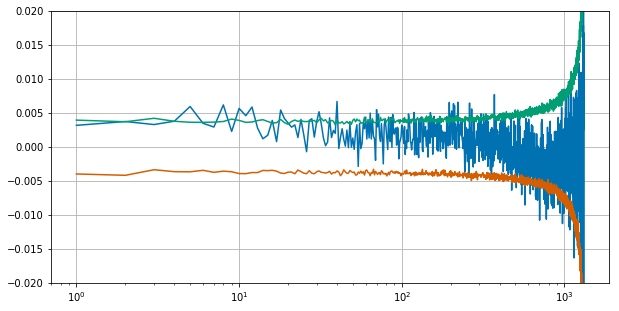

In [318]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.semilogx(raw_autocor)
ax.semilogx(np.percentile(RawShuf,97.5,axis=1))
ax.semilogx(np.percentile(RawShuf,2.5,axis=1))
ax.set_ylim(-0.02,0.02)
ax.grid(True)

In [293]:
NShufs = 1000
shuf_autocor2 = np.zeros((NA,NShufs))
true_scores = (RippleArmScores[anim][day]['TruePercentiles'] - 50)/100

event_indices = np.argwhere(binned_swr_events.data[0,:]==1).squeeze()

import time

t1 = time.time()
for i in range(NShufs):
    if (i % 25 == 0):
        print(i)
    shuf_autocor2[:,i] = shuffle_autocorrelation(event_indices, true_scores, score_time_series.shape[1], sigma)
t2 = time.time()

print('Parallel time: {}. Single thread time: {}'.format(t1-t0,t2-t1))
    

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
Parallel time: 605.2834243774414. Single thread time: 250.37792706489563


In [302]:
shuf_autocor2.shape

(10000, 1000)

(-0.01, 0.01)

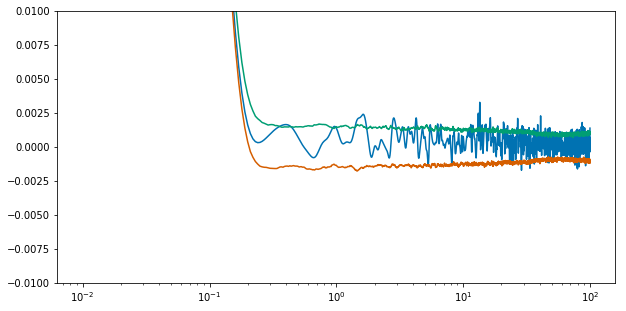

In [301]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.semilogx(np.arange(NA)*ds, autocor*(1/ds)*(1/ds))
ax.semilogx(np.arange(NA)*ds, np.percentile((shuf_autocor2),95,axis=1)*(1/ds)*(1/ds))
ax.semilogx(np.arange(NA)*ds, np.percentile((shuf_autocor2),5,axis=1)*(1/ds)*(1/ds))

ax.set_ylim(-0.01,0.01)


In [102]:
swr_eps.n_epochs

1,315

In [86]:
print(left_odds, right_odds)

print(RippleArmScores[anim][day]['TrueOdds'][ex])

-16192.6737992 -15240.2158853
-1013.92223277


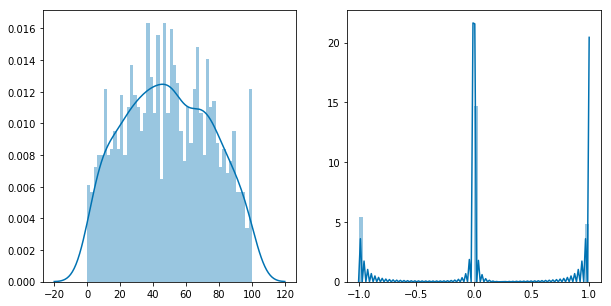

In [49]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sr = np.array(shuf_ratio)
sns.distplot(sr[~np.isnan(sr)],50, ax=ax[0])

sr = np.array(shuf_ratio2)
sns.distplot(sr[~np.isnan(sr)],50, ax=ax[1])

In [53]:
all_score_diffs = []
all_score_diffs_shuff = []
all_last_times = []
NShuf = 500

for anim, ripscores in RippleArmScores.items():
    shuf_ratios = []
    last_ratios = []
    last_times = []
    score_diffs = []
    shuff_score_diffs = []
    for day, datum in ripscores.items():
        sc = np.array(datum['TruePercentilesThresholded'])
        if (len(sc[~np.isnan(sc)]) == 0):
            continue
            
        shuf_ratios.append(sc)
        lastsc = np.array(datum['ScoreOfLastRippleThresholded'])
        last_ratios.append(lastsc)
        lastT = np.array(datum['TimeSinceLastRipple'])
        last_times.append(lastT)
        # score_diffs.append(np.abs(sc - lastsc))
        score_diffs.append(sc*lastsc)
        
        # now we want to generate shuffle distribution of score_diffs
        shuffs = np.zeros((len(sc),NShuf))
        for idx in range(NShuf):
            # shuffs[:,idx] = np.abs(np.random.permutation(sc) - lastsc)
            shuffs[:,idx] = np.random.permutation(sc)*lastsc
        shuff_score_diffs.append(shuffs)
        
        print(day, sc.shape, lastT.shape, lastsc.shape, shuffs.shape)


    all_shuf_ratios = np.hstack(shuf_ratios)
    all_score_diffs.append(np.hstack(score_diffs))
    all_score_diffs_shuff.append(np.vstack(shuff_score_diffs))
    all_last_times.append(np.hstack(last_times))


2013-08-18 (1315,) (1315,) (1315,) (1315, 500)


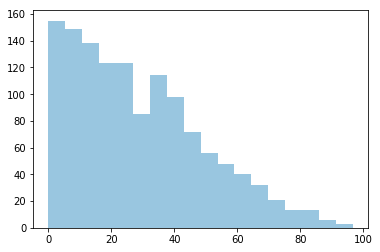

In [30]:
sc = score_diffs[0]
sns.distplot(sc[~np.isnan(sc)], kde=False)

In [39]:
lastT.shape

(1315,)

In [ ]:
print(np.mean(score_diffs[0] == 1))
print(np.mean(np.hstack(shuff_score_diffs[0]) == 1))

In [54]:

bins = np.linspace(-5,5,11)
# actual_diff = sc - lastsc
# actual_diff2 = actual_diff[~np.isnan(actual_diff)]
actual_diff = sc*lastsc

lastT[0] = 10

good = ~np.isnan(actual_diff)
hactual, _ = np.histogram(actual_diff[good], bins=bins)
true_vals, tbins , _ = stats.binned_statistic(np.log10(lastT[good]), actual_diff[good], 'mean', bins=20)

shuf_scores = []
sh_val_list = []
for idx in range(NShuf):
    # shsc = np.abs(np.random.permutation(sc) - lastsc)
    # shsc = np.random.permutation(sc) - lastsc
    shsc = np.random.permutation(sc)*lastsc
    shuf_scores.append(shsc)

    good = ~np.isnan(shsc)

    sh_vals, _, _ = stats.binned_statistic(np.log10(lastT[good]), shsc[good], 'mean', bins=tbins)
    sh_val_list.append(sh_vals)

    



In [37]:
actual_diff.shape

(1290,)

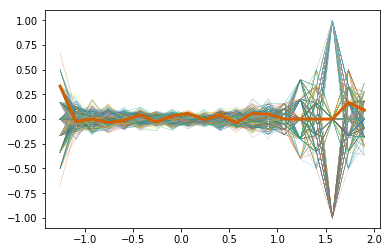

In [55]:
plt.plot(tbins[:-1], np.vstack(sh_val_list).T, lw=0.25);
plt.plot(tbins[:-1], true_vals, lw=3)
